In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../data_in/CE_Crateus.csv'
data_output_path = '../data_out/weather.csv'
data_output_path_npsave = '../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

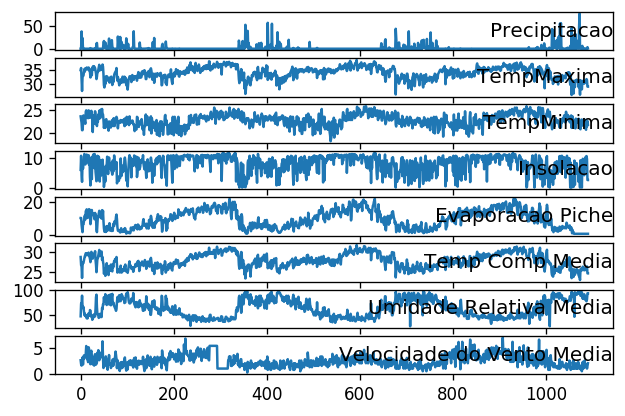

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return model

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# calculate metrics
def metrics(model, x_test, y_test, scaler):
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    rmse = sqrt(mean_squared_error(inv_y_test, inv_y_hat))
    variance = explained_variance_score(inv_y_test, inv_y_hat)
    maxError = np.abs(inv_y_test - inv_y_hat)
    meanAbsolutError = mean_absolute_error(inv_y_test, inv_y_hat)
    medianAbsoluteError = np.abs(inv_y_test - inv_y_hat)
    
    return [rmse, variance, maxError, meanAbsolutError, medianAbsoluteError]

In [11]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler=None):
    metrics_list = []
    rmse = []
    variance = []
    maxError = []
    meanAbsolutError = []
    medianAbsoluteError = []
    i = len(days_to_predict) - 1
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        model = myLSTM(x_train, y_train, x_test, y_test, scaler)    
        metrics_list += metrics(model, x_test, y_test, scaler)
        
        rmse += [metrics_list[0]]
        variance += [metrics_list[1]]
        maxError += [metrics_list[2]]
        meanAbsolutError += [metrics_list[3]]
        medianAbsoluteError += [metrics_list[4]]
        
        i -= 1
        dataset = dataset[:-1]
        
    print('Test RMSE -------------------------- {:.4}'.format(np.mean(rmse)))
    print('Test VARIANCE ---------------------- {:.4}'.format(np.mean(variance)))
    print('Test MAX-ERROR --------------------- {:.4}'.format(np.max(maxError)))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(np.mean(meanAbsolutError)))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(np.median((medianAbsoluteError))))

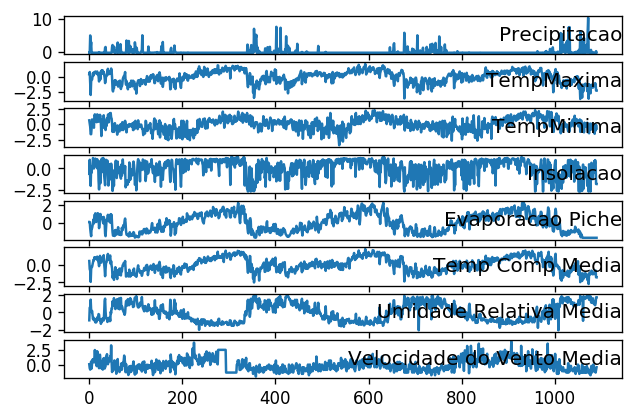

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7237 - mean_squared_error: 0.8295 - val_loss: 0.9973 - val_mean_squared_error: 1.8361
Epoch 2/1000
 - 0s - loss: 0.6078 - mean_squared_error: 0.6272 - val_loss: 0.9043 - val_mean_squared_error: 1.5736
Epoch 3/1000
 - 0s - loss: 0.5851 - mean_squared_error: 0.5785 - val_loss: 0.8484 - val_mean_squared_error: 1.4149
Epoch 4/1000
 - 0s - loss: 0.5626 - mean_squared_error: 0.5456 - val_loss: 0.8995 - val_mean_squared_error: 1.4957
Epoch 5/1000
 - 0s - loss: 0.5504 - mean_squared_error: 0.5239 - val_loss: 0.9995 - val_mean_squared_error: 1.6685
Epoch 6/1000
 - 0s - loss: 0.5381 - mean_squared_error: 0.5095 - val_loss: 1.1729 - val_mean_squared_error: 2.2266
Epoch 7/1000
 - 0s - loss: 0.5292 - mean_squared_error: 0.4946 - val_loss: 1.2520 - val_mean_squared_error: 2.4774
Epoch 8/1000
 - 0s - loss: 0.5234 - mean_squared_error: 0.4851 - val_loss: 1.2324 - val_mean_squared_error: 2.4473
Epoch 9/1000
 - 0s - loss: 0.5168 -

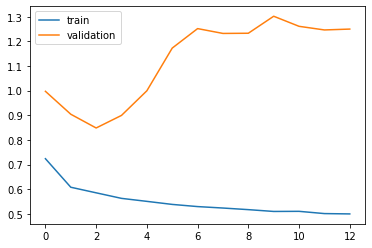


predict: [[-4.31917484 34.00286457]]
real:      [[-14.21823396  32.37202343]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7110 - mean_squared_error: 0.8021 - val_loss: 0.7822 - val_mean_squared_error: 0.6202
Epoch 2/1000
 - 0s - loss: 0.5995 - mean_squared_error: 0.6217 - val_loss: 0.7254 - val_mean_squared_error: 0.5537
Epoch 3/1000
 - 0s - loss: 0.5791 - mean_squared_error: 0.5761 - val_loss: 0.7524 - val_mean_squared_error: 0.5779
Epoch 4/1000
 - 0s - loss: 0.5651 - mean_squared_error: 0.5514 - val_loss: 0.7807 - val_mean_squared_error: 0.6247
Epoch 5/1000
 - 0s - loss: 0.5501 - mean_squared_error: 0.5280 - val_loss: 0.7874 - val_mean_squared_error: 0.6370
Epoch 6/1000
 - 0s - loss: 0.5406 - mean_squared_error: 0.5085 - val_loss: 0.8182 - val_mean_squared_error: 0.6726
Epoch 7/1000
 - 0s - loss: 0.5334 - mean_squared_error: 0.5025 - val_loss: 0.8292 - val_mean_squared_error: 0.6882
Epoch 8/1000
 - 0s - loss: 0.5250 - mean_squared_error: 0.4849 - val_l

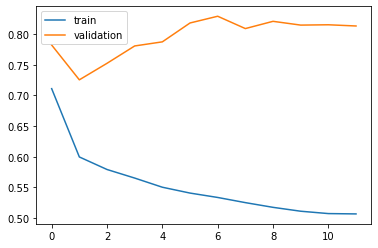


predict: [[-4.43094557 33.77227249]]
real:      [[-14.21823396  33.70050329]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7904 - mean_squared_error: 0.9756 - val_loss: 0.2847 - val_mean_squared_error: 0.1249
Epoch 2/1000
 - 0s - loss: 0.6746 - mean_squared_error: 0.7371 - val_loss: 0.2526 - val_mean_squared_error: 0.0832
Epoch 3/1000
 - 0s - loss: 0.5938 - mean_squared_error: 0.5902 - val_loss: 0.2426 - val_mean_squared_error: 0.0816
Epoch 4/1000
 - 0s - loss: 0.5705 - mean_squared_error: 0.5578 - val_loss: 0.2887 - val_mean_squared_error: 0.1087
Epoch 5/1000
 - 0s - loss: 0.5526 - mean_squared_error: 0.5312 - val_loss: 0.2960 - val_mean_squared_error: 0.1319
Epoch 6/1000
 - 0s - loss: 0.5412 - mean_squared_error: 0.5086 - val_loss: 0.3993 - val_mean_squared_error: 0.2498
Epoch 7/1000
 - 0s - loss: 0.5362 - mean_squared_error: 0.5037 - val_loss: 0.4658 - val_mean_squared_error: 0.3524
Epoch 8/1000
 - 0s - loss: 0.5283 - mean_squared_error: 0.4954 - val_l

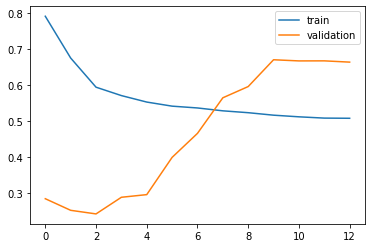


predict: [[-4.08582433 33.78809662]]
real:      [[-6.557701  31.7077835]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7821 - mean_squared_error: 0.9385 - val_loss: 0.9818 - val_mean_squared_error: 1.2362
Epoch 2/1000
 - 0s - loss: 0.6827 - mean_squared_error: 0.7503 - val_loss: 1.0816 - val_mean_squared_error: 1.2824
Epoch 3/1000
 - 0s - loss: 0.5969 - mean_squared_error: 0.5975 - val_loss: 1.0923 - val_mean_squared_error: 1.3361
Epoch 4/1000
 - 0s - loss: 0.5667 - mean_squared_error: 0.5415 - val_loss: 1.0966 - val_mean_squared_error: 1.3260
Epoch 5/1000
 - 0s - loss: 0.5460 - mean_squared_error: 0.5135 - val_loss: 1.1612 - val_mean_squared_error: 1.3993
Epoch 6/1000
 - 0s - loss: 0.5358 - mean_squared_error: 0.4981 - val_loss: 1.1850 - val_mean_squared_error: 1.4815
Epoch 7/1000
 - 0s - loss: 0.5292 - mean_squared_error: 0.4834 - val_loss: 1.1404 - val_mean_squared_error: 1.3389
Epoch 8/1000
 - 0s - loss: 0.5219 - mean_squared_error: 0.4781 - val_loss:

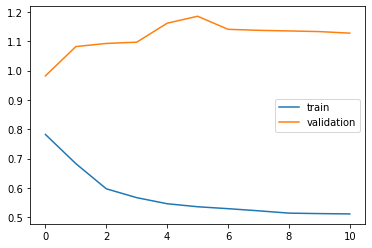


predict: [[-5.60092528 34.04680896]]
real:      [[-5.2809455  34.03262326]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7134 - mean_squared_error: 0.8147 - val_loss: 1.1099 - val_mean_squared_error: 1.2531
Epoch 2/1000
 - 0s - loss: 0.6100 - mean_squared_error: 0.6447 - val_loss: 1.1007 - val_mean_squared_error: 1.2391
Epoch 3/1000
 - 0s - loss: 0.5820 - mean_squared_error: 0.5884 - val_loss: 1.0851 - val_mean_squared_error: 1.1846
Epoch 4/1000
 - 0s - loss: 0.5618 - mean_squared_error: 0.5527 - val_loss: 1.1035 - val_mean_squared_error: 1.2315
Epoch 5/1000
 - 0s - loss: 0.5492 - mean_squared_error: 0.5280 - val_loss: 1.0784 - val_mean_squared_error: 1.1727
Epoch 6/1000
 - 0s - loss: 0.5376 - mean_squared_error: 0.5021 - val_loss: 1.1199 - val_mean_squared_error: 1.2563
Epoch 7/1000
 - 0s - loss: 0.5342 - mean_squared_error: 0.5002 - val_loss: 1.1169 - val_mean_squared_error: 1.2501
Epoch 8/1000
 - 0s - loss: 0.5231 - mean_squared_error: 0.4840 - val_los

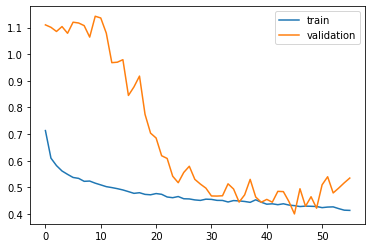


predict: [[-4.05820016 32.58460916]]
real:      [[-7.51526762 30.54536362]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7497 - mean_squared_error: 0.8999 - val_loss: 0.9392 - val_mean_squared_error: 0.8995
Epoch 2/1000
 - 0s - loss: 0.6170 - mean_squared_error: 0.6539 - val_loss: 0.8011 - val_mean_squared_error: 0.6475
Epoch 3/1000
 - 0s - loss: 0.5876 - mean_squared_error: 0.5954 - val_loss: 0.8325 - val_mean_squared_error: 0.7040
Epoch 4/1000
 - 0s - loss: 0.5700 - mean_squared_error: 0.5560 - val_loss: 0.8245 - val_mean_squared_error: 0.6941
Epoch 5/1000
 - 0s - loss: 0.5490 - mean_squared_error: 0.5259 - val_loss: 0.8384 - val_mean_squared_error: 0.7328
Epoch 6/1000
 - 0s - loss: 0.5416 - mean_squared_error: 0.5119 - val_loss: 0.8636 - val_mean_squared_error: 0.8109
Epoch 7/1000
 - 0s - loss: 0.5325 - mean_squared_error: 0.4998 - val_loss: 0.8499 - val_mean_squared_error: 0.7912
Epoch 8/1000
 - 0s - loss: 0.5271 - mean_squared_error: 0.4885 - val_los

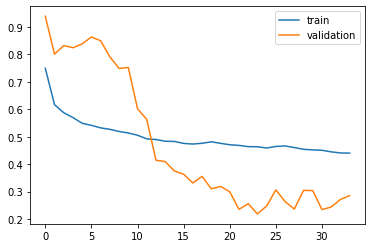


predict: [[-4.68202035 33.15074205]]
real:      [[-8.47283424 30.87748359]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7265 - mean_squared_error: 0.8267 - val_loss: 0.6058 - val_mean_squared_error: 0.4743
Epoch 2/1000
 - 0s - loss: 0.6283 - mean_squared_error: 0.6412 - val_loss: 0.7587 - val_mean_squared_error: 0.7244
Epoch 3/1000
 - 0s - loss: 0.5723 - mean_squared_error: 0.5581 - val_loss: 0.7200 - val_mean_squared_error: 0.6811
Epoch 4/1000
 - 0s - loss: 0.5516 - mean_squared_error: 0.5229 - val_loss: 0.6862 - val_mean_squared_error: 0.6391
Epoch 5/1000
 - 0s - loss: 0.5402 - mean_squared_error: 0.5114 - val_loss: 0.7149 - val_mean_squared_error: 0.7087
Epoch 6/1000
 - 0s - loss: 0.5324 - mean_squared_error: 0.4973 - val_loss: 0.8038 - val_mean_squared_error: 0.8616
Epoch 7/1000
 - 0s - loss: 0.5282 - mean_squared_error: 0.4947 - val_loss: 0.7629 - val_mean_squared_error: 0.7849
Epoch 8/1000
 - 0s - loss: 0.5220 - mean_squared_error: 0.4830 - val_los

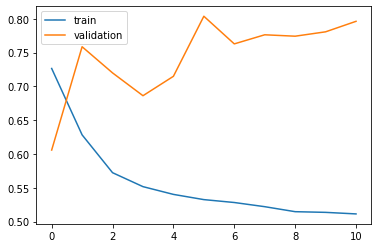


predict: [[-3.98071396 33.52838151]]
real:      [[-8.79202311 32.03990347]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7308 - mean_squared_error: 0.8364 - val_loss: 0.7268 - val_mean_squared_error: 0.9085
Epoch 2/1000
 - 0s - loss: 0.6086 - mean_squared_error: 0.6229 - val_loss: 0.7651 - val_mean_squared_error: 0.8577
Epoch 3/1000
 - 0s - loss: 0.5701 - mean_squared_error: 0.5531 - val_loss: 0.7808 - val_mean_squared_error: 0.8534
Epoch 4/1000
 - 0s - loss: 0.5495 - mean_squared_error: 0.5202 - val_loss: 0.8287 - val_mean_squared_error: 0.9570
Epoch 5/1000
 - 0s - loss: 0.5406 - mean_squared_error: 0.5054 - val_loss: 0.9056 - val_mean_squared_error: 1.1544
Epoch 6/1000
 - 0s - loss: 0.5297 - mean_squared_error: 0.4974 - val_loss: 0.8800 - val_mean_squared_error: 1.0632
Epoch 7/1000
 - 0s - loss: 0.5226 - mean_squared_error: 0.4826 - val_loss: 1.0664 - val_mean_squared_error: 1.3833
Epoch 8/1000
 - 0s - loss: 0.5218 - mean_squared_error: 0.4800 - val_los

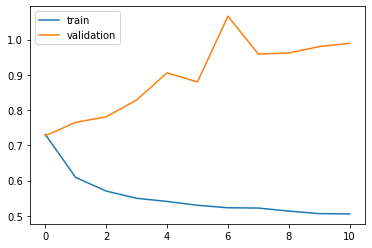


predict: [[-3.78217389 34.30065318]]
real:      [[-9.74958973 33.03626336]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7637 - mean_squared_error: 0.9088 - val_loss: 0.6183 - val_mean_squared_error: 0.5230
Epoch 2/1000
 - 0s - loss: 0.6301 - mean_squared_error: 0.6448 - val_loss: 0.5147 - val_mean_squared_error: 0.4198
Epoch 3/1000
 - 0s - loss: 0.5735 - mean_squared_error: 0.5598 - val_loss: 0.5249 - val_mean_squared_error: 0.3867
Epoch 4/1000
 - 0s - loss: 0.5549 - mean_squared_error: 0.5314 - val_loss: 0.6553 - val_mean_squared_error: 0.5774
Epoch 5/1000
 - 0s - loss: 0.5429 - mean_squared_error: 0.5115 - val_loss: 0.5807 - val_mean_squared_error: 0.5140
Epoch 6/1000
 - 0s - loss: 0.5363 - mean_squared_error: 0.5004 - val_loss: 0.6739 - val_mean_squared_error: 0.6710
Epoch 7/1000
 - 0s - loss: 0.5332 - mean_squared_error: 0.5010 - val_loss: 0.7268 - val_mean_squared_error: 0.7105
Epoch 8/1000
 - 0s - loss: 0.5262 - mean_squared_error: 0.4871 - val_los

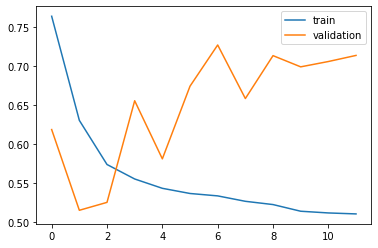


predict: [[-3.77150879 33.42194912]]
real:      [[-10.70715635  34.36474322]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7540 - mean_squared_error: 0.9088 - val_loss: 0.4199 - val_mean_squared_error: 0.2143
Epoch 2/1000
 - 0s - loss: 0.6228 - mean_squared_error: 0.6423 - val_loss: 0.4675 - val_mean_squared_error: 0.2617
Epoch 3/1000
 - 0s - loss: 0.5834 - mean_squared_error: 0.5776 - val_loss: 0.5014 - val_mean_squared_error: 0.2998
Epoch 4/1000
 - 0s - loss: 0.5660 - mean_squared_error: 0.5498 - val_loss: 0.5126 - val_mean_squared_error: 0.3143
Epoch 5/1000
 - 0s - loss: 0.5493 - mean_squared_error: 0.5313 - val_loss: 0.5331 - val_mean_squared_error: 0.3453
Epoch 6/1000
 - 0s - loss: 0.5358 - mean_squared_error: 0.5101 - val_loss: 0.5421 - val_mean_squared_error: 0.3746
Epoch 7/1000
 - 0s - loss: 0.5287 - mean_squared_error: 0.4984 - val_loss: 0.5573 - val_mean_squared_error: 0.4214
Epoch 8/1000
 - 0s - loss: 0.5245 - mean_squared_error: 0.4884 - val_l

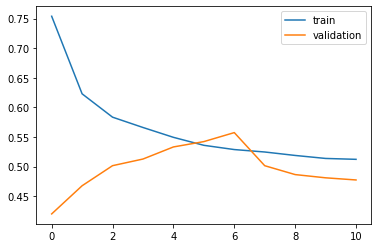


predict: [[-3.62334645 33.65755846]]
real:      [[-7.19607874 33.86656328]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7680 - mean_squared_error: 0.9156 - val_loss: 0.6908 - val_mean_squared_error: 0.6857
Epoch 2/1000
 - 0s - loss: 0.6553 - mean_squared_error: 0.7055 - val_loss: 0.6065 - val_mean_squared_error: 0.5100
Epoch 3/1000
 - 0s - loss: 0.5934 - mean_squared_error: 0.6021 - val_loss: 0.4159 - val_mean_squared_error: 0.3038
Epoch 4/1000
 - 0s - loss: 0.5685 - mean_squared_error: 0.5552 - val_loss: 0.3962 - val_mean_squared_error: 0.2768
Epoch 5/1000
 - 0s - loss: 0.5548 - mean_squared_error: 0.5374 - val_loss: 0.4551 - val_mean_squared_error: 0.3742
Epoch 6/1000
 - 0s - loss: 0.5452 - mean_squared_error: 0.5270 - val_loss: 0.4615 - val_mean_squared_error: 0.4240
Epoch 7/1000
 - 0s - loss: 0.5319 - mean_squared_error: 0.5099 - val_loss: 0.4035 - val_mean_squared_error: 0.3202
Epoch 8/1000
 - 0s - loss: 0.5310 - mean_squared_error: 0.5022 - val_los

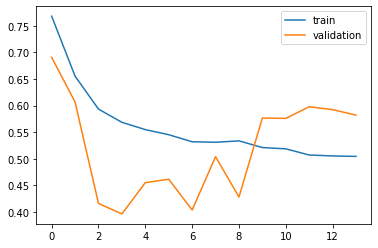


predict: [[-3.52237603 33.46817155]]
real:      [[-7.19607874 33.03626336]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7536 - mean_squared_error: 0.8861 - val_loss: 0.8996 - val_mean_squared_error: 0.8306
Epoch 2/1000
 - 0s - loss: 0.6360 - mean_squared_error: 0.6622 - val_loss: 0.8912 - val_mean_squared_error: 0.7958
Epoch 3/1000
 - 0s - loss: 0.5765 - mean_squared_error: 0.5776 - val_loss: 0.8803 - val_mean_squared_error: 0.7752
Epoch 4/1000
 - 0s - loss: 0.5544 - mean_squared_error: 0.5353 - val_loss: 0.8970 - val_mean_squared_error: 0.8083
Epoch 5/1000
 - 0s - loss: 0.5429 - mean_squared_error: 0.5242 - val_loss: 0.8006 - val_mean_squared_error: 0.6466
Epoch 6/1000
 - 0s - loss: 0.5394 - mean_squared_error: 0.5135 - val_loss: 0.8610 - val_mean_squared_error: 0.7546
Epoch 7/1000
 - 0s - loss: 0.5286 - mean_squared_error: 0.4929 - val_loss: 0.8559 - val_mean_squared_error: 0.7599
Epoch 8/1000
 - 0s - loss: 0.5264 - mean_squared_error: 0.4847 - val_los

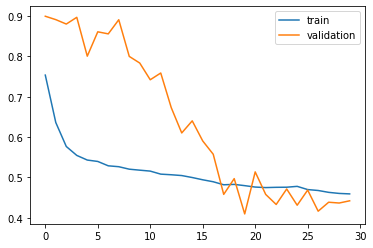


predict: [[-3.79423163 33.13640182]]
real:      [[-7.51526762 33.86656328]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8019 - mean_squared_error: 0.9905 - val_loss: 1.2959 - val_mean_squared_error: 3.1820
Epoch 2/1000
 - 0s - loss: 0.6556 - mean_squared_error: 0.7127 - val_loss: 1.1788 - val_mean_squared_error: 2.6797
Epoch 3/1000
 - 0s - loss: 0.5766 - mean_squared_error: 0.5798 - val_loss: 1.1071 - val_mean_squared_error: 2.2785
Epoch 4/1000
 - 0s - loss: 0.5508 - mean_squared_error: 0.5320 - val_loss: 1.1509 - val_mean_squared_error: 2.2439
Epoch 5/1000
 - 0s - loss: 0.5412 - mean_squared_error: 0.5161 - val_loss: 1.1806 - val_mean_squared_error: 2.2815
Epoch 6/1000
 - 0s - loss: 0.5346 - mean_squared_error: 0.5040 - val_loss: 1.2187 - val_mean_squared_error: 2.4995
Epoch 7/1000
 - 0s - loss: 0.5310 - mean_squared_error: 0.4958 - val_loss: 1.2985 - val_mean_squared_error: 2.7865
Epoch 8/1000
 - 0s - loss: 0.5254 - mean_squared_error: 0.4927 - val_los

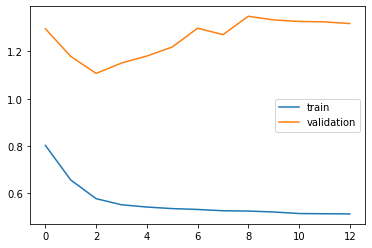


predict: [[-3.43116432 33.76194487]]
real:      [[-8.47283424 32.03990347]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7108 - mean_squared_error: 0.8096 - val_loss: 0.8467 - val_mean_squared_error: 1.1653
Epoch 2/1000
 - 0s - loss: 0.5889 - mean_squared_error: 0.5869 - val_loss: 0.7504 - val_mean_squared_error: 0.8383
Epoch 3/1000
 - 0s - loss: 0.5587 - mean_squared_error: 0.5394 - val_loss: 0.7901 - val_mean_squared_error: 0.9445
Epoch 4/1000
 - 0s - loss: 0.5408 - mean_squared_error: 0.5125 - val_loss: 0.8261 - val_mean_squared_error: 0.9822
Epoch 5/1000
 - 0s - loss: 0.5362 - mean_squared_error: 0.5089 - val_loss: 0.9111 - val_mean_squared_error: 1.0954
Epoch 6/1000
 - 0s - loss: 0.5291 - mean_squared_error: 0.4884 - val_loss: 0.9267 - val_mean_squared_error: 1.0999
Epoch 7/1000
 - 0s - loss: 0.5190 - mean_squared_error: 0.4779 - val_loss: 0.9674 - val_mean_squared_error: 1.1286
Epoch 8/1000
 - 0s - loss: 0.5202 - mean_squared_error: 0.4731 - val_los

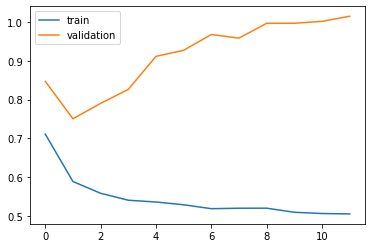


predict: [[-5.41668739 33.36987392]]
real:      [[-17.41012269  34.19868324]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7354 - mean_squared_error: 0.8437 - val_loss: 0.9408 - val_mean_squared_error: 0.8885
Epoch 2/1000
 - 0s - loss: 0.6279 - mean_squared_error: 0.6531 - val_loss: 1.0308 - val_mean_squared_error: 1.0900
Epoch 3/1000
 - 0s - loss: 0.5734 - mean_squared_error: 0.5723 - val_loss: 1.0255 - val_mean_squared_error: 1.0898
Epoch 4/1000
 - 0s - loss: 0.5522 - mean_squared_error: 0.5326 - val_loss: 0.9395 - val_mean_squared_error: 0.8918
Epoch 5/1000
 - 0s - loss: 0.5421 - mean_squared_error: 0.5188 - val_loss: 0.9996 - val_mean_squared_error: 1.0304
Epoch 6/1000
 - 0s - loss: 0.5318 - mean_squared_error: 0.5053 - val_loss: 0.9227 - val_mean_squared_error: 0.8876
Epoch 7/1000
 - 0s - loss: 0.5294 - mean_squared_error: 0.5012 - val_loss: 0.9206 - val_mean_squared_error: 0.9125
Epoch 8/1000
 - 0s - loss: 0.5166 - mean_squared_error: 0.4866 - val_l

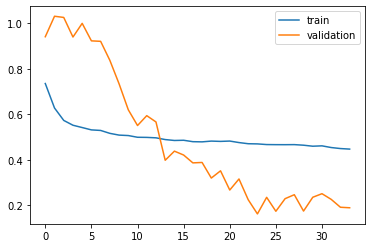


predict: [[-5.76367856 33.10766991]]
real:      [[-12.30310072  34.19868324]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7255 - mean_squared_error: 0.8427 - val_loss: 1.2574 - val_mean_squared_error: 1.7044
Epoch 2/1000
 - 0s - loss: 0.6183 - mean_squared_error: 0.6448 - val_loss: 1.1127 - val_mean_squared_error: 1.4379
Epoch 3/1000
 - 0s - loss: 0.5712 - mean_squared_error: 0.5600 - val_loss: 1.0483 - val_mean_squared_error: 1.2680
Epoch 4/1000
 - 0s - loss: 0.5509 - mean_squared_error: 0.5284 - val_loss: 1.0436 - val_mean_squared_error: 1.2376
Epoch 5/1000
 - 0s - loss: 0.5431 - mean_squared_error: 0.5153 - val_loss: 1.0711 - val_mean_squared_error: 1.2506
Epoch 6/1000
 - 0s - loss: 0.5354 - mean_squared_error: 0.5029 - val_loss: 1.0456 - val_mean_squared_error: 1.2059
Epoch 7/1000
 - 0s - loss: 0.5340 - mean_squared_error: 0.5031 - val_loss: 1.0672 - val_mean_squared_error: 1.2552
Epoch 8/1000
 - 0s - loss: 0.5260 - mean_squared_error: 0.4905 - val_l

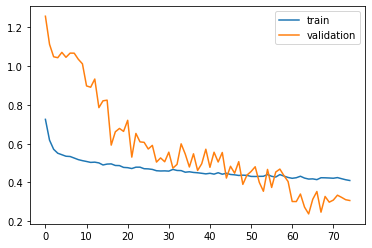


predict: [[-4.44160257 32.33479731]]
real:      [[-8.47283424 32.20596345]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7335 - mean_squared_error: 0.8432 - val_loss: 2.0676 - val_mean_squared_error: 5.0341
Epoch 2/1000
 - 0s - loss: 0.6229 - mean_squared_error: 0.6405 - val_loss: 2.0216 - val_mean_squared_error: 4.8041
Epoch 3/1000
 - 0s - loss: 0.5620 - mean_squared_error: 0.5506 - val_loss: 2.0211 - val_mean_squared_error: 5.0135
Epoch 4/1000
 - 0s - loss: 0.5368 - mean_squared_error: 0.5056 - val_loss: 2.1615 - val_mean_squared_error: 5.5121
Epoch 5/1000
 - 0s - loss: 0.5366 - mean_squared_error: 0.5030 - val_loss: 2.0781 - val_mean_squared_error: 5.2418
Epoch 6/1000
 - 0s - loss: 0.5281 - mean_squared_error: 0.4941 - val_loss: 2.1091 - val_mean_squared_error: 5.4104
Epoch 7/1000
 - 0s - loss: 0.5192 - mean_squared_error: 0.4720 - val_loss: 2.1080 - val_mean_squared_error: 5.4166
Epoch 8/1000
 - 0s - loss: 0.5163 - mean_squared_error: 0.4630 - val_los

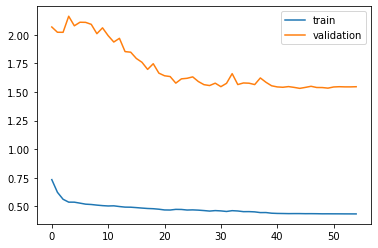


predict: [[-6.54341594 32.57850396]]
real:      [[-6.557701   30.71142361]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7026 - mean_squared_error: 0.7804 - val_loss: 1.5436 - val_mean_squared_error: 2.4444
Epoch 2/1000
 - 0s - loss: 0.6033 - mean_squared_error: 0.6132 - val_loss: 1.3917 - val_mean_squared_error: 1.9495
Epoch 3/1000
 - 0s - loss: 0.5673 - mean_squared_error: 0.5511 - val_loss: 1.3847 - val_mean_squared_error: 1.9329
Epoch 4/1000
 - 0s - loss: 0.5419 - mean_squared_error: 0.5141 - val_loss: 1.4255 - val_mean_squared_error: 2.0669
Epoch 5/1000
 - 0s - loss: 0.5300 - mean_squared_error: 0.4961 - val_loss: 1.4252 - val_mean_squared_error: 2.0786
Epoch 6/1000
 - 0s - loss: 0.5236 - mean_squared_error: 0.4804 - val_loss: 1.3865 - val_mean_squared_error: 2.0201
Epoch 7/1000
 - 0s - loss: 0.5178 - mean_squared_error: 0.4774 - val_loss: 1.3812 - val_mean_squared_error: 1.9979
Epoch 8/1000
 - 0s - loss: 0.5102 - mean_squared_error: 0.4626 - val_los

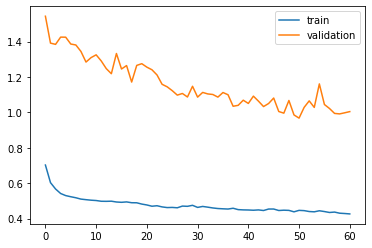


predict: [[-5.95782488 32.19092517]]
real:      [[-23.79390016  31.20960355]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7300 - mean_squared_error: 0.8413 - val_loss: 1.0042 - val_mean_squared_error: 1.0306
Epoch 2/1000
 - 0s - loss: 0.6185 - mean_squared_error: 0.6391 - val_loss: 0.8986 - val_mean_squared_error: 0.8414
Epoch 3/1000
 - 0s - loss: 0.5720 - mean_squared_error: 0.5546 - val_loss: 0.7405 - val_mean_squared_error: 0.5550
Epoch 4/1000
 - 0s - loss: 0.5457 - mean_squared_error: 0.5119 - val_loss: 0.7695 - val_mean_squared_error: 0.5973
Epoch 5/1000
 - 0s - loss: 0.5325 - mean_squared_error: 0.5077 - val_loss: 0.7475 - val_mean_squared_error: 0.5598
Epoch 6/1000
 - 0s - loss: 0.5224 - mean_squared_error: 0.4814 - val_loss: 0.7594 - val_mean_squared_error: 0.5842
Epoch 7/1000
 - 0s - loss: 0.5129 - mean_squared_error: 0.4699 - val_loss: 0.8129 - val_mean_squared_error: 0.6609
Epoch 8/1000
 - 0s - loss: 0.5111 - mean_squared_error: 0.4763 - val_l

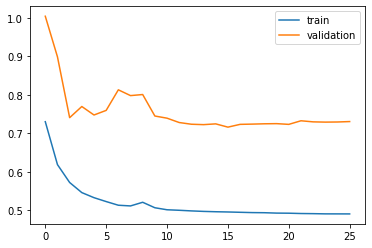


predict: [[-2.84155444 33.39990065]]
real:      [[-13.26066734  31.04354357]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7492 - mean_squared_error: 0.8753 - val_loss: 1.0085 - val_mean_squared_error: 1.4926
Epoch 2/1000
 - 0s - loss: 0.6611 - mean_squared_error: 0.7150 - val_loss: 1.0512 - val_mean_squared_error: 1.6882
Epoch 3/1000
 - 0s - loss: 0.5781 - mean_squared_error: 0.5731 - val_loss: 1.0634 - val_mean_squared_error: 1.7459
Epoch 4/1000
 - 0s - loss: 0.5469 - mean_squared_error: 0.5216 - val_loss: 1.0462 - val_mean_squared_error: 1.5635
Epoch 5/1000
 - 0s - loss: 0.5289 - mean_squared_error: 0.4863 - val_loss: 1.1027 - val_mean_squared_error: 1.6499
Epoch 6/1000
 - 0s - loss: 0.5282 - mean_squared_error: 0.4761 - val_loss: 1.1044 - val_mean_squared_error: 1.7161
Epoch 7/1000
 - 0s - loss: 0.5236 - mean_squared_error: 0.4697 - val_loss: 1.1290 - val_mean_squared_error: 1.7172
Epoch 8/1000
 - 0s - loss: 0.5160 - mean_squared_error: 0.4669 - val_l

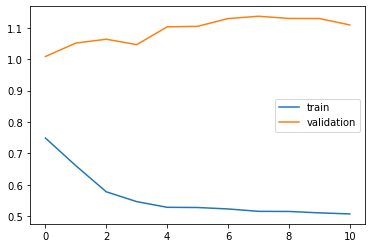


predict: [[-5.48501417 33.55548278]]
real:      [[-7.19607874 32.03990347]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7129 - mean_squared_error: 0.8003 - val_loss: 0.4761 - val_mean_squared_error: 0.2274
Epoch 2/1000
 - 0s - loss: 0.5948 - mean_squared_error: 0.5869 - val_loss: 0.4642 - val_mean_squared_error: 0.2190
Epoch 3/1000
 - 0s - loss: 0.5510 - mean_squared_error: 0.5165 - val_loss: 0.4347 - val_mean_squared_error: 0.1954
Epoch 4/1000
 - 0s - loss: 0.5342 - mean_squared_error: 0.4981 - val_loss: 0.4545 - val_mean_squared_error: 0.2130
Epoch 5/1000
 - 0s - loss: 0.5265 - mean_squared_error: 0.4817 - val_loss: 0.5173 - val_mean_squared_error: 0.2760
Epoch 6/1000
 - 0s - loss: 0.5244 - mean_squared_error: 0.4819 - val_loss: 0.5258 - val_mean_squared_error: 0.3033
Epoch 7/1000
 - 0s - loss: 0.5261 - mean_squared_error: 0.4807 - val_loss: 0.4500 - val_mean_squared_error: 0.2105
Epoch 8/1000
 - 0s - loss: 0.5371 - mean_squared_error: 0.5135 - val_los

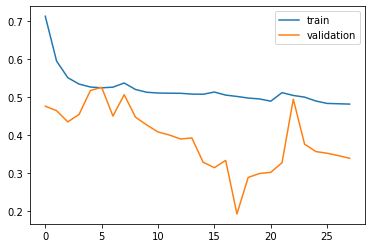


predict: [[-7.63856122 32.88940103]]
real:      [[-14.8566117   34.53080321]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7454 - mean_squared_error: 0.8663 - val_loss: 0.5145 - val_mean_squared_error: 0.3223
Epoch 2/1000
 - 0s - loss: 0.6621 - mean_squared_error: 0.6954 - val_loss: 0.5276 - val_mean_squared_error: 0.2904
Epoch 3/1000
 - 0s - loss: 0.5782 - mean_squared_error: 0.5568 - val_loss: 0.5366 - val_mean_squared_error: 0.3075
Epoch 4/1000
 - 0s - loss: 0.5343 - mean_squared_error: 0.4890 - val_loss: 0.4910 - val_mean_squared_error: 0.2586
Epoch 5/1000
 - 0s - loss: 0.5247 - mean_squared_error: 0.4790 - val_loss: 0.4416 - val_mean_squared_error: 0.2105
Epoch 6/1000
 - 0s - loss: 0.5137 - mean_squared_error: 0.4651 - val_loss: 0.5243 - val_mean_squared_error: 0.2849
Epoch 7/1000
 - 0s - loss: 0.5086 - mean_squared_error: 0.4593 - val_loss: 0.4526 - val_mean_squared_error: 0.2136
Epoch 8/1000
 - 0s - loss: 0.5028 - mean_squared_error: 0.4570 - val_l

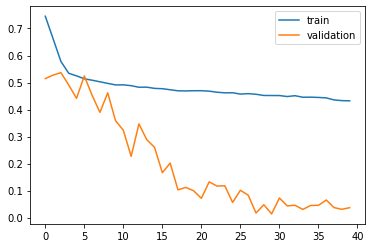


predict: [[-5.35234872 33.16972596]]
real:      [[-6.87688987 33.03626336]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7073 - mean_squared_error: 0.7884 - val_loss: 0.4609 - val_mean_squared_error: 0.3912
Epoch 2/1000
 - 0s - loss: 0.5972 - mean_squared_error: 0.5933 - val_loss: 0.5806 - val_mean_squared_error: 0.5149
Epoch 3/1000
 - 0s - loss: 0.5570 - mean_squared_error: 0.5282 - val_loss: 0.6030 - val_mean_squared_error: 0.5342
Epoch 4/1000
 - 0s - loss: 0.5384 - mean_squared_error: 0.4982 - val_loss: 0.5512 - val_mean_squared_error: 0.4598
Epoch 5/1000
 - 0s - loss: 0.5262 - mean_squared_error: 0.4824 - val_loss: 0.4254 - val_mean_squared_error: 0.2901
Epoch 6/1000
 - 0s - loss: 0.5222 - mean_squared_error: 0.4753 - val_loss: 0.3430 - val_mean_squared_error: 0.1997
Epoch 7/1000
 - 0s - loss: 0.5151 - mean_squared_error: 0.4702 - val_loss: 0.3214 - val_mean_squared_error: 0.1446
Epoch 8/1000
 - 0s - loss: 0.5102 - mean_squared_error: 0.4627 - val_los

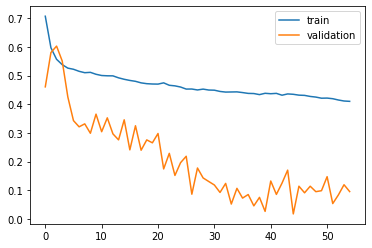


predict: [[-5.57845026 33.03391994]]
real:      [[-7.19607874 33.03626336]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7269 - mean_squared_error: 0.8360 - val_loss: 0.3465 - val_mean_squared_error: 0.2153
Epoch 2/1000
 - 0s - loss: 0.6161 - mean_squared_error: 0.6402 - val_loss: 0.2626 - val_mean_squared_error: 0.1305
Epoch 3/1000
 - 0s - loss: 0.5616 - mean_squared_error: 0.5442 - val_loss: 0.3327 - val_mean_squared_error: 0.1158
Epoch 4/1000
 - 0s - loss: 0.5407 - mean_squared_error: 0.5091 - val_loss: 0.3128 - val_mean_squared_error: 0.1151
Epoch 5/1000
 - 0s - loss: 0.5273 - mean_squared_error: 0.4870 - val_loss: 0.2693 - val_mean_squared_error: 0.0947
Epoch 6/1000
 - 0s - loss: 0.5201 - mean_squared_error: 0.4750 - val_loss: 0.3303 - val_mean_squared_error: 0.1098
Epoch 7/1000
 - 0s - loss: 0.5142 - mean_squared_error: 0.4672 - val_loss: 0.3181 - val_mean_squared_error: 0.1012
Epoch 8/1000
 - 0s - loss: 0.5076 - mean_squared_error: 0.4611 - val_los

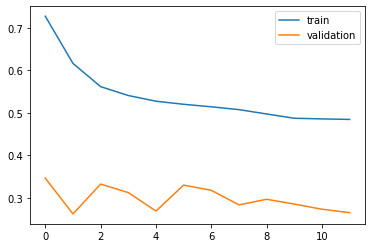


predict: [[-4.70973025 33.6173927 ]]
real:      [[-7.51526762 33.86656328]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7255 - mean_squared_error: 0.8339 - val_loss: 0.5582 - val_mean_squared_error: 0.3690
Epoch 2/1000
 - 0s - loss: 0.5997 - mean_squared_error: 0.6008 - val_loss: 0.4521 - val_mean_squared_error: 0.2743
Epoch 3/1000
 - 0s - loss: 0.5493 - mean_squared_error: 0.5197 - val_loss: 0.3752 - val_mean_squared_error: 0.1721
Epoch 4/1000
 - 0s - loss: 0.5273 - mean_squared_error: 0.4923 - val_loss: 0.3914 - val_mean_squared_error: 0.1702
Epoch 5/1000
 - 0s - loss: 0.5104 - mean_squared_error: 0.4697 - val_loss: 0.4009 - val_mean_squared_error: 0.2160
Epoch 6/1000
 - 0s - loss: 0.5034 - mean_squared_error: 0.4556 - val_loss: 0.4072 - val_mean_squared_error: 0.1783
Epoch 7/1000
 - 0s - loss: 0.4992 - mean_squared_error: 0.4533 - val_loss: 0.4024 - val_mean_squared_error: 0.1837
Epoch 8/1000
 - 0s - loss: 0.4941 - mean_squared_error: 0.4408 - val_los

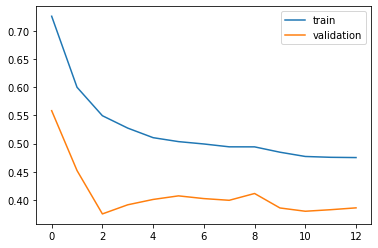


predict: [[-5.51952006 33.45643008]]
real:      [[-5.91932325 34.19868324]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7003 - mean_squared_error: 0.8075 - val_loss: 0.7291 - val_mean_squared_error: 0.7533
Epoch 2/1000
 - 0s - loss: 0.6125 - mean_squared_error: 0.6300 - val_loss: 0.6793 - val_mean_squared_error: 0.6060
Epoch 3/1000
 - 0s - loss: 0.5695 - mean_squared_error: 0.5541 - val_loss: 0.6156 - val_mean_squared_error: 0.4350
Epoch 4/1000
 - 0s - loss: 0.5415 - mean_squared_error: 0.5132 - val_loss: 0.5520 - val_mean_squared_error: 0.3994
Epoch 5/1000
 - 0s - loss: 0.5224 - mean_squared_error: 0.4897 - val_loss: 0.4950 - val_mean_squared_error: 0.2761
Epoch 6/1000
 - 0s - loss: 0.5124 - mean_squared_error: 0.4701 - val_loss: 0.4727 - val_mean_squared_error: 0.2439
Epoch 7/1000
 - 0s - loss: 0.5024 - mean_squared_error: 0.4549 - val_loss: 0.4552 - val_mean_squared_error: 0.2291
Epoch 8/1000
 - 0s - loss: 0.4959 - mean_squared_error: 0.4463 - val_los

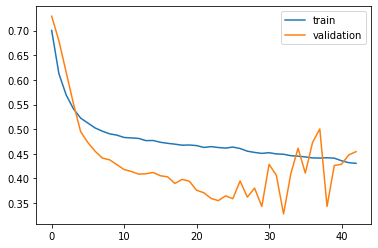


predict: [[-4.43562808 33.38342827]]
real:      [[-7.83445649 34.03262326]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7512 - mean_squared_error: 0.8989 - val_loss: 1.4182 - val_mean_squared_error: 2.0316
Epoch 2/1000
 - 0s - loss: 0.6570 - mean_squared_error: 0.7246 - val_loss: 1.4326 - val_mean_squared_error: 2.0813
Epoch 3/1000
 - 0s - loss: 0.6160 - mean_squared_error: 0.6507 - val_loss: 1.3218 - val_mean_squared_error: 1.7641
Epoch 4/1000
 - 0s - loss: 0.5839 - mean_squared_error: 0.5979 - val_loss: 1.2910 - val_mean_squared_error: 1.7471
Epoch 5/1000
 - 0s - loss: 0.5583 - mean_squared_error: 0.5500 - val_loss: 1.2016 - val_mean_squared_error: 1.5463
Epoch 6/1000
 - 0s - loss: 0.5428 - mean_squared_error: 0.5212 - val_loss: 1.1480 - val_mean_squared_error: 1.4960
Epoch 7/1000
 - 0s - loss: 0.5307 - mean_squared_error: 0.5011 - val_loss: 1.0313 - val_mean_squared_error: 1.1889
Epoch 8/1000
 - 0s - loss: 0.5198 - mean_squared_error: 0.4837 - val_los

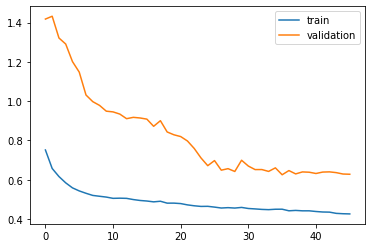


predict: [[-5.81611517 33.33790594]]
real:      [[-6.87688987 34.53080321]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7375 - mean_squared_error: 0.8385 - val_loss: 0.8793 - val_mean_squared_error: 1.4116
Epoch 2/1000
 - 0s - loss: 0.6605 - mean_squared_error: 0.6911 - val_loss: 0.9348 - val_mean_squared_error: 1.6610
Epoch 3/1000
 - 0s - loss: 0.5970 - mean_squared_error: 0.5860 - val_loss: 0.8662 - val_mean_squared_error: 1.4358
Epoch 4/1000
 - 0s - loss: 0.5549 - mean_squared_error: 0.5201 - val_loss: 0.9000 - val_mean_squared_error: 1.5142
Epoch 5/1000
 - 0s - loss: 0.5358 - mean_squared_error: 0.4975 - val_loss: 0.8565 - val_mean_squared_error: 1.3134
Epoch 6/1000
 - 0s - loss: 0.5320 - mean_squared_error: 0.4905 - val_loss: 0.8177 - val_mean_squared_error: 1.2238
Epoch 7/1000
 - 0s - loss: 0.5263 - mean_squared_error: 0.4827 - val_loss: 0.8724 - val_mean_squared_error: 1.4224
Epoch 8/1000
 - 0s - loss: 0.5166 - mean_squared_error: 0.4720 - val_los

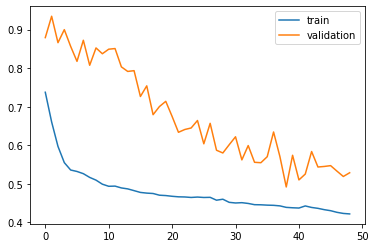


predict: [[-4.23647722 33.47187634]]
real:      [[-7.51526762 31.04354357]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7121 - mean_squared_error: 0.8147 - val_loss: 0.7311 - val_mean_squared_error: 0.8009
Epoch 2/1000
 - 0s - loss: 0.6297 - mean_squared_error: 0.6570 - val_loss: 0.6506 - val_mean_squared_error: 0.8009
Epoch 3/1000
 - 0s - loss: 0.5756 - mean_squared_error: 0.5704 - val_loss: 0.7012 - val_mean_squared_error: 0.8084
Epoch 4/1000
 - 0s - loss: 0.5512 - mean_squared_error: 0.5195 - val_loss: 0.6909 - val_mean_squared_error: 0.7297
Epoch 5/1000
 - 0s - loss: 0.5353 - mean_squared_error: 0.4965 - val_loss: 0.6521 - val_mean_squared_error: 0.6619
Epoch 6/1000
 - 0s - loss: 0.5257 - mean_squared_error: 0.4785 - val_loss: 0.5380 - val_mean_squared_error: 0.5607
Epoch 7/1000
 - 0s - loss: 0.5175 - mean_squared_error: 0.4748 - val_loss: 0.5137 - val_mean_squared_error: 0.4887
Epoch 8/1000
 - 0s - loss: 0.5132 - mean_squared_error: 0.4654 - val_los

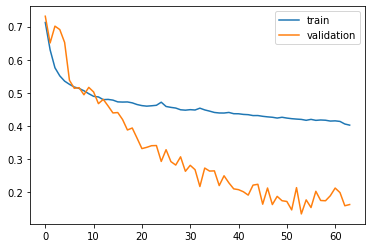


predict: [[-4.91865305 33.60919199]]
real:      [[-14.8566117   33.86656328]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6930 - mean_squared_error: 0.7986 - val_loss: 1.0369 - val_mean_squared_error: 1.0753
Epoch 2/1000
 - 0s - loss: 0.6064 - mean_squared_error: 0.6217 - val_loss: 0.8535 - val_mean_squared_error: 0.7452
Epoch 3/1000
 - 0s - loss: 0.5669 - mean_squared_error: 0.5449 - val_loss: 0.7328 - val_mean_squared_error: 0.5442
Epoch 4/1000
 - 0s - loss: 0.5435 - mean_squared_error: 0.5047 - val_loss: 0.7299 - val_mean_squared_error: 0.5407
Epoch 5/1000
 - 0s - loss: 0.5286 - mean_squared_error: 0.4870 - val_loss: 0.6917 - val_mean_squared_error: 0.4861
Epoch 6/1000
 - 0s - loss: 0.5175 - mean_squared_error: 0.4760 - val_loss: 0.6740 - val_mean_squared_error: 0.4605
Epoch 7/1000
 - 0s - loss: 0.5075 - mean_squared_error: 0.4614 - val_loss: 0.6269 - val_mean_squared_error: 0.3982
Epoch 8/1000
 - 0s - loss: 0.4992 - mean_squared_error: 0.4527 - val_l

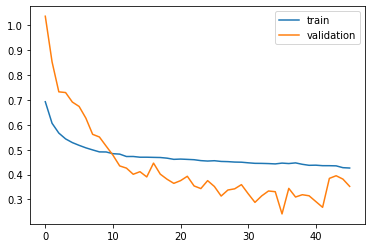


predict: [[-2.80117984 33.41844471]]
real:      [[-10.38796748  34.03262326]]

Test RMSE -------------------------- 7.094
Test VARIANCE ---------------------- 1.0
Test MAX-ERROR --------------------- 9.899
Test MEAN-ABSOLUTE-ERROR ----------- 5.765
Test MEDIAN-ABSOLUTE-ERROR --------- 5.765


In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

standart_scaler = preprocessing.StandardScaler()
values_scaled = standart_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

NCV(dataset_scaled, days_to_predict, standart_scaler)